In [ ]:
!pip install tensorflow==2.0.0
import tensorflow as tf
tf.test.gpu_device_name()

In [ ]:
import pandas as pd
import io
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
import sklearn
from sklearn.metrics import mean_squared_log_error as MSLE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [ ]:
# Upload the files
from google.colab import files

In [ ]:
uploaded = files.upload()

Saving train.csv to train (2).csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['train.csv']))
df.head()

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Sales
0,44113,1,49,Business,Course,0,1,0,12999,0.024,76
1,181755,1,200,Business,Course,0,1,1,10122,0.001,42
2,221525,1,243,Business,Course,0,1,0,36771,0.016,174
3,392733,1,431,Business,Degree,0,1,1,26208,0.011,91
4,541678,1,594,Business,Degree,0,1,0,29505,0.009,107


In [ ]:
uploaded2 = files.upload()

Saving test.csv to test.csv


In [ ]:
zz = pd.read_csv(io.BytesIO(uploaded2['test.csv']))
zz.head()

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,Competition_Metric
0,883,883,1,Development,Course,1,0,1,0.007
1,884,884,1,Development,Course,1,0,1,0.007
2,885,885,1,Development,Course,1,0,1,0.007
3,886,886,1,Development,Course,1,0,1,0.007
4,887,887,1,Development,Course,0,0,1,0.007


In [ ]:
print(df.shape)
print(df.columns)

(512087, 11)
Index(['ID', 'Day_No', 'Course_ID', 'Course_Domain', 'Course_Type',
       'Short_Promotion', 'Public_Holiday', 'Long_Promotion', 'User_Traffic',
       'Competition_Metric', 'Sales'],
      dtype='object')


In [ ]:
#drop unnecessary ones
df.drop(['ID','Course_Domain', 'Course_Type', 'User_Traffic' ], axis=1, inplace=True)
df = df.sort_values(by=['Day_No', 'Course_ID'])

In [ ]:
#drop unnecessary ones
zz.drop(['ID','Course_Domain', 'Course_Type'], axis=1, inplace=True)
zz = zz.sort_values(by=['Day_No', 'Course_ID'])

In [ ]:
print(df.dtypes)
print(zz.dtypes)

Day_No                  int64
Course_ID               int64
Short_Promotion         int64
Public_Holiday          int64
Long_Promotion          int64
Competition_Metric    float64
Sales                   int64
dtype: object
Day_No                  int64
Course_ID               int64
Short_Promotion         int64
Public_Holiday          int64
Long_Promotion          int64
Competition_Metric    float64
dtype: object


In [ ]:
#Creating Target Data
# Expected to predict for 20 days. So we need to shift the data 20 time-steps to predict the sales for 20 days into the future
tar_cid = 600 #course id - for all courses we need to predict
target_names = 'Sales'
shift_days = 1
shift_steps = shift_days * 600*20 #Expected to predict for 20 days and there are 600 courses so around 1200 steps
shift_steps

12000

Create a new data-frame with the time-shifted data.

Note the negative time-shift!
df_targets = dt[target_names].shift(-shift_steps)

In [ ]:
dt=df.copy() #just for the ease of not changing the entire code.

In [ ]:
df_targets = dt[target_names].shift(-shift_steps) #12001th record has moved to 1st place/index and the tail is showing NAN
df_targets

5         108.0
6         196.0
190       137.0
7          83.0
191       112.0
          ...  
511798      NaN
511677      NaN
511888      NaN
511799      NaN
512086      NaN
Name: Sales, Length: 512087, dtype: float64

In [ ]:
#These are the input-signals:
x_data = dt.values[0:-shift_steps]
print(type(x_data))
print("Shape:", x_data.shape)
array_sum = np.sum(x_data)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)
x_data = np.nan_to_num(x_data)

<class 'numpy.ndarray'>
Shape: (500087, 7)
True


In [ ]:
ana = zz.values
type(ana)

numpy.ndarray

In [ ]:
ana.shape

(36000, 6)

In [ ]:
#These are the output-signals (or target-signals):
y_data = df_targets.values[:-shift_steps]
print(type(y_data))
print("Shape:", y_data.shape)
array_sum = np.sum(y_data)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)
y_data = np.nan_to_num(y_data)

<class 'numpy.ndarray'>
Shape: (500087,)
False


In [ ]:
#This is the number of observations (aka. data-points or samples) in the data-set:
num_data = len(x_data)
num_data

500087

In [ ]:
#This is the fraction of the data-set that will be used for the training-set:
train_split = 0.9

In [ ]:
#This is the number of observations in the training-set:
num_train = int(train_split * num_data)
num_train

450078

In [ ]:
#This is the number of observations in the test-set:
num_test = num_data - num_train
num_test

50009

In [ ]:
#These are the input-signals for the training- and test-sets:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

500087

In [ ]:
x_test.shape

(50009, 7)

In [ ]:
#These are the output-signals for the training- and test-sets:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

500087

In [ ]:
#This is the number of input-signals:
num_x_signals = x_data.shape[1]
num_x_signals

7

In [ ]:
#This is the number of output-signals:
print(y_data.shape)
num_y_signals = 1
print(num_y_signals)

(500087,)
1


In [ ]:
x_train.shape

(450078, 7)

In [ ]:
x_test.shape

(50009, 7)

In [ ]:
#need to deop the x_test of the y values
x_test.drop['Sales', axis=1, inplace=True]

**SCALING THE DATA**

In [ ]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 0.0
Max: 779.0


In [ ]:
x_train

array([[1.00e+00, 1.00e+00, 0.00e+00, ..., 1.00e+00, 7.00e-03, 8.10e+01],
       [1.00e+00, 2.00e+00, 0.00e+00, ..., 1.00e+00, 1.86e-01, 9.70e+01],
       [1.00e+00, 3.00e+00, 0.00e+00, ..., 0.00e+00, 3.16e-01, 8.00e+01],
       ...,
       [7.79e+02, 3.89e+02, 1.00e+00, ..., 1.00e+00, 2.47e-01, 6.40e+01],
       [7.79e+02, 3.90e+02, 1.00e+00, ..., 0.00e+00, 1.98e-01, 1.24e+02],
       [7.79e+02, 3.91e+02, 1.00e+00, ..., 0.00e+00, 1.00e-03, 1.09e+02]])

In [ ]:
#We first create a scaler-object for the input-signals.
x_scaler = MinMaxScaler()
print(x_train.shape)
print(x_test.shape)
print(ana.shape)

(450078, 7)
(50009, 7)
(36000, 6)


In [ ]:
#We then detect the range of values from the training-data and scale the training-data.
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)
x_ana_scaled = x_scaler.fit_transform(ana)

In [ ]:
array_sum = np.sum(x_train)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)

False


In [ ]:
#Ignore the rounding error of 2 in the end
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [ ]:
y_scaler = MinMaxScaler()
y_train.shape

(450078, 1)

In [ ]:
#In the shape number of columns is zero. The code y_train.reshape(-1, 1) helps to add a dimension. This is applicable only for single column problem
y_train = y_train.reshape(-1, 1)
print(y_train.shape)

(450078, 1)


In [ ]:
y_test = y_test.reshape(-1, 1)
print(y_test.shape)

(50009, 1)


In [ ]:
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

**Data Generator**

In [ ]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(450078, 7)
(450078, 1)


In [ ]:
num_train

450078

In [ ]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            #num_train itself is 775 so, cannot take sequence length beyond 600... as it may break the data
            idx = np.random.randint(num_train - sequence_length) 
                        
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [ ]:
# batch size can be between 50 to 256 only. Let me go for max GPU
batch_size = 200
# sequence length... approximately taking 1800
sequence_length = 600 * 1

In [ ]:
#We then create the batch-generator.
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)
#We can then test the batch-generator to see if it works.
x_batch, y_batch = next(generator)

In [ ]:
print(x_batch.shape)
print(y_batch.shape)

(200, 600, 7)
(200, 600, 1)


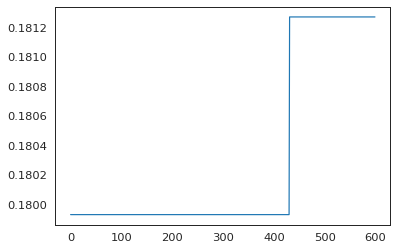

In [ ]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 8 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

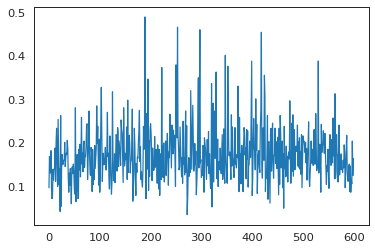

In [ ]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [ ]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [ ]:
model = Sequential()

In [ ]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [ ]:
model.add(Dense(num_y_signals, activation='sigmoid'))

In [ ]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)
    
    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [ ]:
warmup_steps = 50

In [ ]:
def loss_msle_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    #msle = tf.keras.losses.MSLE(y_true_slice, y_pred_slice)
    #msle = square(log(y_true_slice) - log(y_pred_slice))
    
    return mse

In [ ]:
optimizer = RMSprop(lr=1e-3)

In [ ]:
model.compile(loss=tf.keras.losses.MeanSquaredLogarithmicError(), optimizer=optimizer)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 512)         800256    
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           513       
Total params: 800,769
Trainable params: 800,769
Non-trainable params: 0
_________________________________________________________________


**Callback Functions**

In [ ]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [ ]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [ ]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [ ]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [ ]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

**Train the Recurrent Neural Network**

In [ ]:
%%time
model.fit(x=generator,
          epochs=5,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

Train for 100 steps, validate on 1 samples
Epoch 1/5


In [ ]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [ ]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 10s 10s/sample - loss: 0.0026


In [ ]:
print("loss (test-set):", result)

loss (test-set): 0.0026187035255134106


In [ ]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

In [ ]:
#y_pred = model.predict(x)

In [ ]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

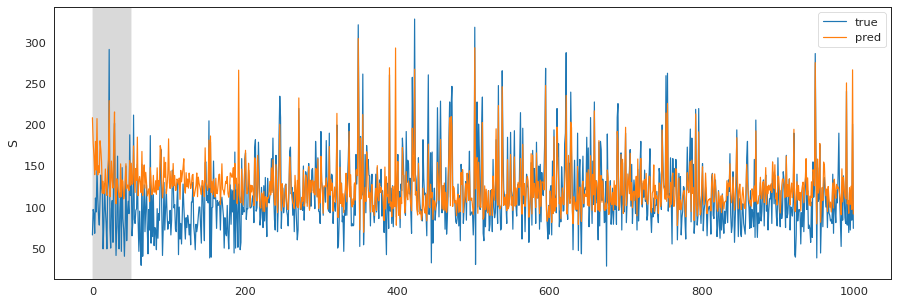

IndexError: ignored

In [ ]:
plot_comparison(start_idx=100000, length=1000, train=True)

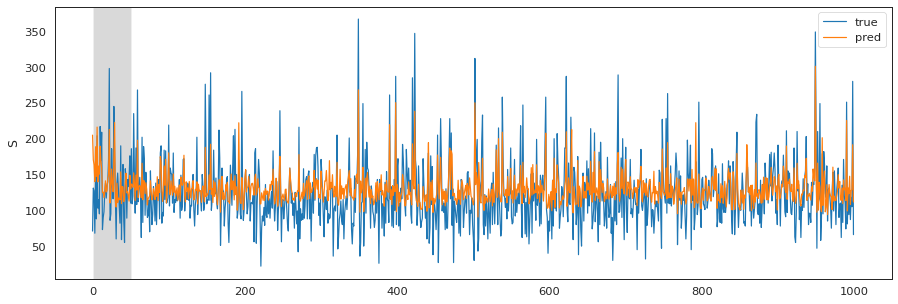

IndexError: ignored

In [ ]:
plot_comparison(start_idx=10000, length=1000, train=True)

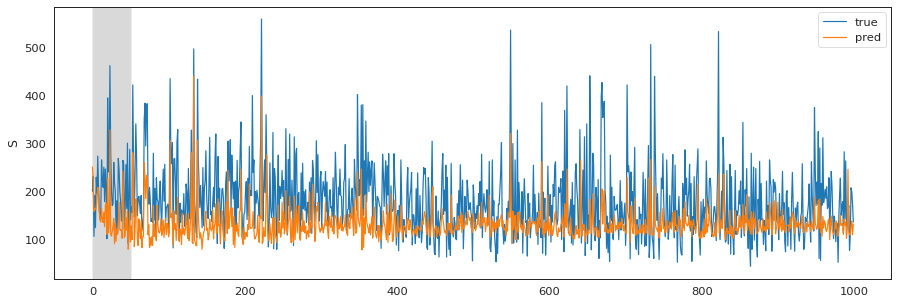

IndexError: ignored

In [ ]:
plot_comparison(start_idx=200000, length=1000, train=True)

In [ ]:
x = x_test_scaled
y_true = y_test
# Input-signals for the model.
x = np.expand_dims(x, axis=0)

# Use the model to predict the output-signals.
y_pred = model.predict(x)

ERROR! Session/line number was not unique in database. History logging moved to new session 70


In [ ]:
from tensorflow.keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# later...
 
## load json and create model
#json_file = open('model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
## load weights into new model
#loaded_model.load_weights("model.h5")
#print("Loaded model from disk")
## evaluate loaded model on test data
#loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#score = loaded_model.evaluate(X, Y, verbose=0)
#print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [ ]:
# Use test-data.
x = x_test_scaled
y_true = y_test
    
# Input-signals for the model.
x = np.expand_dims(x, axis=0)

# Use the model to predict the output-signals.
y_pred = model.predict(x)
    
# The output of the model is between 0 and 1.
# Do an inverse map to get it back to the scale
# of the original data-set.
y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
y_pred_rescaled

array([[220.01779 ],
       [149.99866 ],
       [118.08971 ],
       ...,
       [130.78284 ],
       [120.45411 ],
       [110.371216]], dtype=float32)